# Compare accuracies

In [1]:
import os
import fnmatch
import pandas as pd
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from utils import isolate_int, flatten_2D_list
from data_extractor import output_vars_v4
import numpy as np
from copy import deepcopy

In [2]:
path = 'saved_models/'
model_prefixes = ['TEST9_global_v4_all_channels_depth_', 'TEST9_sel1_depth_']
labels = ['All features', 'Selection of features']
val = pd.read_pickle('extracted_data/TEST9_global_v4_or&norm_weights_val')

In [3]:
vars_list = []

with open('saved_results/features&label_all_v4', 'rb') as file:
        vars_all_v4 = pickle.load(file)
vars_list.append(vars_all_v4)

with open('saved_results/features&label_sel1', 'rb') as file:
        vars_sel1 = pickle.load(file)
vars_list.append(vars_sel1)

In [4]:
print(vars_sel1)

['mt_1MET', 'HNL_CM_mass_with_MET_1', 'mt_12', 'mass_12', 'pt_2', 'mass_123', 'HNL_CM_mass_2', 'mt_1(3MET)', 'mt_23', 'HNL_CM_mass_1', 'HNL_CM_mass_with_MET_2', 'mt_3MET', 'pt_MET', 'mass_23', 'mt_2(1MET)', 'mt_1(2MET)', 'mt_MET(23)', 'Mt_tot', 'mt_MET(13)', 'mass_hyp', 'pt_123', 'pt_1', 'mt_2MET', 'mt_3(2MET)', 'mt_1(23)', 'mt_2(13)', 'mass_13', 'mt_13', 'channel', 'signal_label']


In [6]:
model_names_list = []
depths_list = []
for model_prefix in model_prefixes:
    model_names = fnmatch.filter(os.listdir(path), model_prefix+'*')
    model_names_list.append(model_names)
    depths = []
    for name in model_names:
        depth = isolate_int(name, separators='_')[0]
        depths.append(depth)
    depths_list.append(depths)

In [7]:
def eval_accuracies(model_names, val, selected_vars):
    x_val = val[selected_vars]
    label_val = x_val.pop('signal_label').astype(float)
    weighted_accs = []
    for model_name in model_names:
        model = tf.keras.models.load_model(path+model_name)
        results = model.evaluate(x_val, label_val, sample_weight=val['weightNorm'])
        weighted_accs.append(results[-1])
    return weighted_accs


In [8]:
weighted_accs_list = []
for i, model_names in enumerate(model_names_list):
    weighted_accs = eval_accuracies(model_names, val, vars_list[i])
    weighted_accs_list.append(weighted_accs)

2023-05-28 22:49:16.971929: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-28 22:49:17.957517: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6673 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-05-28 22:49:17.958254: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6653 MB memory:  -> device: 1, name: Quadro RTX 4000, pci bus id: 0000:65:00.0, compute capability: 7.5


6295/6295 [==============================] - 24s 4ms/step - loss: 0.1487 - accuracy: 0.6510 - weighted_accuracy: 0.9464


In [20]:
sizes_list = []
for model_names in model_names_list:
    sizes = []
    for model_name in model_names:
        model = tf.keras.models.load_model(path+model_name)
        sizes.append(model.count_params())
    sizes_list.append(sizes)

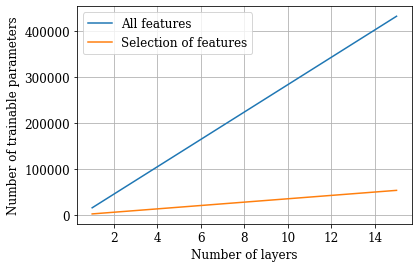

In [21]:
import matplotlib as mpl 
mpl.rcParams.update({"font.size": 12, "font.family": "serif"})
for i in range(len(depths_list)):
    x, y = zip(*sorted(list(zip(depths_list[i], sizes_list[i])), key=lambda x: x[0]))
    plt.plot(x, y,label=labels[i])
plt.xlabel('Number of layers')
plt.ylabel('Number of trainable parameters')
plt.legend()
plt.grid()

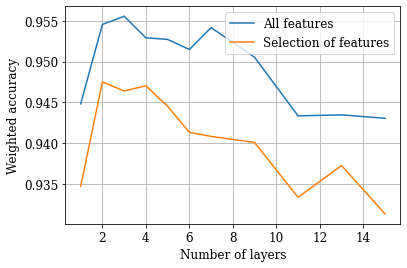

In [17]:
import matplotlib as mpl 
mpl.rcParams.update({"font.size": 12, "font.family": "serif"})
for i in range(len(depths_list)):
    x, y = zip(*sorted(list(zip(depths_list[i], weighted_accs_list[i])), key=lambda x: x[0]))
    plt.plot(x, y,label=labels[i])
plt.xlabel('Number of layers')
plt.ylabel('Weighted accuracy')
plt.legend()
plt.grid()
plt.savefig('Images/TEST9_global_v4_accuracy_vs_n_layers.pdf', bbox_inches='tight')

# Compare poisson significance estimator

In [1]:
from metrics import poisson_significance
import pandas as pd
from utils import plot_hist, isolate_int
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import fnmatch
import tensorflow as tf
from copy import deepcopy

In [2]:
path = 'saved_models/'
model_prefixes = ['TEST9_global_v4_all_channels_depth_', 'TEST9_sel1_depth_']
labels = ['All features', 'Selection of features']
val = pd.read_pickle('extracted_data/TEST9_global_v4_or&norm_weights_val')
vars_list = []

with open('saved_results/features&label_all_v4', 'rb') as file:
        vars_all_v4 = pickle.load(file)
vars_list.append(vars_all_v4)

with open('saved_results/features&label_sel1', 'rb') as file:
        vars_sel1 = pickle.load(file)
vars_list.append(vars_sel1)

In [3]:
model_names_list = []
depths_list = []
for model_prefix in model_prefixes:
    model_names = fnmatch.filter(os.listdir(path), model_prefix+'*')
    model_names_list.append(model_names)
    depths = []
    for name in model_names:
        depth = isolate_int(name, separators='_')[0]
        depths.append(depth)
    depths_list.append(depths)

In [38]:
print(len(val[val['channel'] == 0]))

7961


100%|██████████| 100/100 [00:00<00:00, 1876.00it/s]


[]


100%|██████████| 100/100 [00:00<00:00, 1069.82it/s]


[4.77148659e-12 1.01010101e-02 2.02020202e-02 3.03030303e-02
 4.04040404e-02 5.05050505e-02 6.06060606e-02 7.07070707e-02
 8.08080808e-02 9.09090909e-02 1.01010101e-01 1.11111111e-01
 1.21212121e-01 1.31313131e-01 1.41414141e-01 1.51515152e-01
 1.61616162e-01 1.71717172e-01 1.81818182e-01 1.91919192e-01
 2.02020202e-01 2.12121212e-01 2.22222222e-01 2.32323232e-01
 2.42424242e-01 2.52525253e-01 2.62626263e-01 2.72727273e-01
 2.82828283e-01 2.92929293e-01 3.03030303e-01 3.13131313e-01
 3.23232323e-01 3.33333333e-01 3.43434343e-01 3.53535354e-01
 3.63636364e-01 3.73737374e-01 3.83838384e-01 3.93939394e-01
 4.04040404e-01 4.14141414e-01 4.24242424e-01 4.34343434e-01
 4.44444444e-01 4.54545455e-01 4.64646465e-01 4.74747475e-01
 4.84848485e-01 4.94949495e-01 5.05050505e-01 5.15151515e-01
 5.25252525e-01 5.35353535e-01 5.45454545e-01 5.55555556e-01
 5.65656566e-01 5.75757576e-01 5.85858586e-01 5.95959596e-01
 6.06060606e-01 6.16161616e-01 6.26262626e-01 6.36363636e-01
 6.46464646e-01 6.565656

100%|██████████| 100/100 [00:00<00:00, 712.68it/s]


[4.15836853e-12 1.01010101e-02 2.02020202e-02 3.03030303e-02
 4.04040404e-02 5.05050505e-02 6.06060606e-02 7.07070707e-02
 8.08080808e-02 9.09090909e-02 1.01010101e-01 1.11111111e-01
 1.21212121e-01 1.31313131e-01 1.41414141e-01 1.51515152e-01
 1.61616162e-01 1.71717172e-01 1.81818182e-01 1.91919192e-01
 2.02020202e-01 2.12121212e-01 2.22222222e-01 2.32323232e-01
 2.42424242e-01 2.52525253e-01 2.62626263e-01 2.72727273e-01
 2.82828283e-01 2.92929293e-01 3.03030303e-01 3.13131313e-01
 3.23232323e-01 3.33333333e-01 3.43434343e-01 3.53535354e-01
 3.63636364e-01 3.73737374e-01 3.83838384e-01 3.93939394e-01
 4.04040404e-01 4.14141414e-01 4.24242424e-01 4.34343434e-01
 4.44444444e-01 4.54545455e-01 4.64646465e-01 4.74747475e-01
 4.84848485e-01 4.94949495e-01 5.05050505e-01 5.15151515e-01
 5.25252525e-01 5.35353535e-01 5.45454545e-01 5.55555556e-01
 5.65656566e-01 5.75757576e-01 5.85858586e-01 5.95959596e-01
 6.06060606e-01 6.16161616e-01 6.26262626e-01 6.36363636e-01
 6.46464646e-01 6.565656

100%|██████████| 100/100 [00:00<00:00, 1018.59it/s]


[1.55100555e-08 1.01010255e-02 2.02020354e-02 3.03030453e-02
 4.04040553e-02 5.05050652e-02 6.06060752e-02 7.07070851e-02
 8.08080951e-02 9.09091050e-02 1.01010115e-01 1.11111125e-01
 1.21212135e-01 1.31313145e-01 1.41414155e-01 1.51515165e-01
 1.61616175e-01 1.71717185e-01 1.81818195e-01 1.91919204e-01
 2.02020214e-01 2.12121224e-01 2.22222234e-01 2.32323244e-01
 2.42424254e-01 2.52525264e-01 2.62626274e-01 2.72727284e-01
 2.82828294e-01 2.92929304e-01 3.03030314e-01 3.13131324e-01
 3.23232334e-01 3.33333344e-01 3.43434354e-01 3.53535364e-01
 3.63636374e-01 3.73737383e-01 3.83838393e-01 3.93939403e-01
 4.04040413e-01 4.14141423e-01 4.24242433e-01 4.34343443e-01
 4.44444453e-01 4.54545463e-01 4.64646473e-01 4.74747483e-01
 4.84848493e-01 4.94949503e-01 5.05050513e-01 5.15151523e-01
 5.25252533e-01 5.35353543e-01 5.45454553e-01 5.55555562e-01
 5.65656572e-01 5.75757582e-01 5.85858592e-01 5.95959602e-01
 6.06060612e-01 6.16161622e-01 6.26262632e-01 6.36363642e-01
 6.46464652e-01 6.565656

100%|██████████| 100/100 [00:00<00:00, 1106.07it/s]


[6.82911931e-08 1.01010777e-02 2.02020871e-02 3.03030965e-02
 4.04041059e-02 5.05051153e-02 6.06061248e-02 7.07071342e-02
 8.08081436e-02 9.09091530e-02 1.01010162e-01 1.11111172e-01
 1.21212181e-01 1.31313191e-01 1.41414200e-01 1.51515209e-01
 1.61616219e-01 1.71717228e-01 1.81818238e-01 1.91919247e-01
 2.02020257e-01 2.12121266e-01 2.22222275e-01 2.32323285e-01
 2.42424294e-01 2.52525304e-01 2.62626313e-01 2.72727322e-01
 2.82828332e-01 2.92929341e-01 3.03030351e-01 3.13131360e-01
 3.23232369e-01 3.33333379e-01 3.43434388e-01 3.53535398e-01
 3.63636407e-01 3.73737417e-01 3.83838426e-01 3.93939435e-01
 4.04040445e-01 4.14141454e-01 4.24242464e-01 4.34343473e-01
 4.44444482e-01 4.54545492e-01 4.64646501e-01 4.74747511e-01
 4.84848520e-01 4.94949529e-01 5.05050539e-01 5.15151548e-01
 5.25252558e-01 5.35353567e-01 5.45454576e-01 5.55555586e-01
 5.65656595e-01 5.75757605e-01 5.85858614e-01 5.95959624e-01
 6.06060633e-01 6.16161642e-01 6.26262652e-01 6.36363661e-01
 6.46464671e-01 6.565656

ValueError: attempt to get argmax of an empty sequence

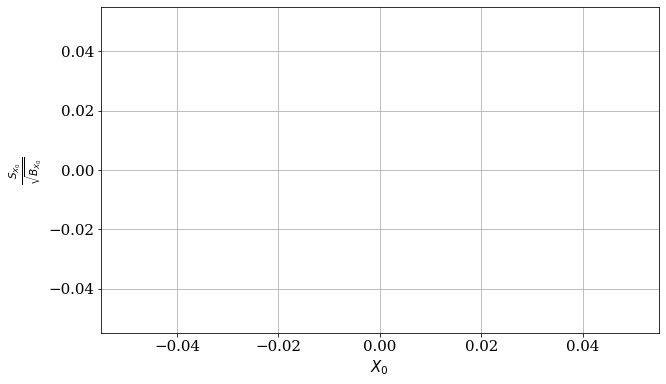

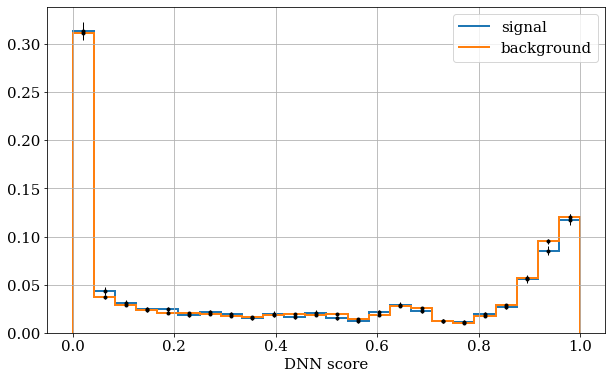

In [32]:
#Lists of results and plot with the same structure as the model_names_list:
#First index for the width of the DNN (either all features, or the selection)
#and second index for the depth of the DNN
x0s_list = []
significances = []
sigs_plots = []
hists_plots = []

with open('extracted_data/TEST9_global_v4_all_normalized_channel_indices', 'rb') as file:
    channel_indices = pickle.load(file)

for i, model_names in enumerate(model_names_list):
    x_val = val[vars_list[i]]
    label_val = x_val.pop('signal_label').astype(float)
    sigs = []
    x0s = []
    sigs_plot = []
    hists_plot = []
    for j, model_name in enumerate(model_names):
        model = tf.keras.models.load_model(path+model_name)
        #Create the lists for the results for 1 width (and all depths)
        bins_list = []
        sigs_list = []

        scores = np.array([])
        for channel in channel_indices:
            x_val_channel = x_val[val['channel'] == channel_indices[channel]]
            label_val_channel = label_val[val['channel'] == channel_indices[channel]]
            scores_channel = model.predict(x_val_channel)
            scores_channel = np.squeeze(scores_channel)
            scores = np.append(scores, scores_channel)

            sig, bins = poisson_significance(scores_channel, label_val_channel, val['weightOriginal'][val['channel'] == channel_indices[channel]], 100)
            sigs.append(sig)
            print(bins)
            bins_list.append(bins)
        
        #select results that could be computed at a definite X_0 for all channels
        common_x0 = bins_list[0]
        for b in bins_list[1:]:
            common_x0 = np.intersect1d(common_x0, b)
        #sig_cmb is defined as the sqrt of the sum of the significances squared for all channels
        sig_cmb = np.zeros_like(common_x0)
        for i, sig in enumerate(sigs_list):
            indices = np.searchsorted(bins_list[i], common_x0)
            selected_sig = sig[indices]
            sig_cmb += np.square(selected_sig)
        sig_cmb = np.sqrt(sig_cmb)
        
        x0s.append(common_x0)
        sigs.append(sig_cmb)

        fig_s, ax_s = plt.subplots(1, 1, figsize=(10, 6))
        ax_s.plot(common_x0,sig_cmb)
        ax_s.set_xlabel('$X_0$')
        ax_s.set_ylabel(r'$\frac{S_{X_0}}{\sqrt{B_{X_0}}}$')
        ax_s.grid()
        sigs_plot.append(fig_s)

        val_mod = deepcopy(val)
        val_mod['scores'] = scores
        hist_bins = np.linspace(0,1,25)
        fig = plot_hist(val_mod, 'scores', 'DNN score', hist_bins, mode='simple_signal_label', weights_name='weightOriginal')[0]
        ax = fig.gca()
        ax.axvline(common_x0[np.argmax(sig_cmb)], color='k', linestyle='--', label='$X_0$')
        hists_plot.append(fig)

    x0s_list.append(x0s)
    significances.append(sigs)
    sigs_plots.append(sigs_plot)
    hists_plots.append(hists_plot)

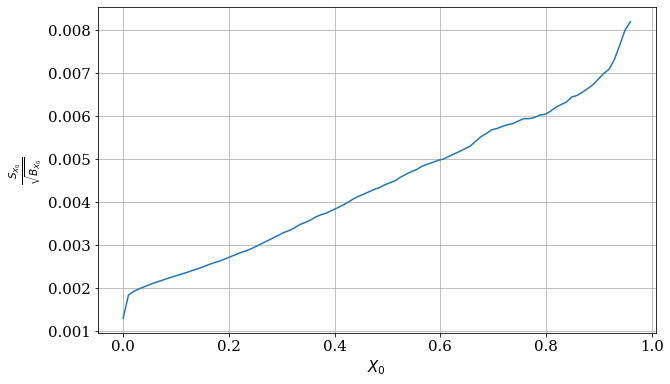

In [28]:
from IPython.display import display
import matplotlib as mpl
fig = sigs_plots[0][0]
ax = fig.gca()
ax.axis('on')
fig.patch.set_facecolor('white')
for text in fig.findobj(mpl.text.Text):
    text.set_fontsize(15)
    text.set_fontfamily('serif')
display(fig)

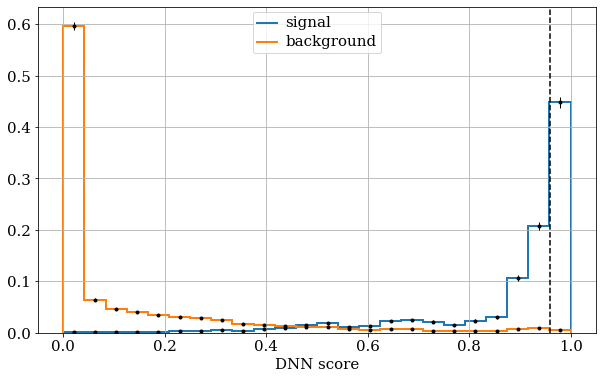

In [29]:
fig = hists_plots[0][0]
ax = fig.gca()
ax.axis('on')
fig.patch.set_facecolor('white')
for text in fig.findobj(mpl.text.Text):
    text.set_fontsize(15)
    text.set_fontfamily('serif')
display(fig)

In [5]:
max_sigs_list = []
for sigs in significances:
    max_sigs = []
    for sig in sigs:
        max_sigs.append(max(sig))
    max_sigs_list.append(max_sigs)


In [6]:
print(max_sigs_list)
print(depths_list)

[[0.008198048165582167, 0.009537360041645382, 0.008130743111218662, 0.00909888758763519, 0.009049624430006188, 0.007609071579826934, 0.009329988005965753, 0.009066305392428595, 0.009271414853635928, 0.0070114910681229395, 0.008153634325835947], [0.009068169740769412, 0.007060871329258248, 0.008261953903973007, 0.008181769264946492, 0.008464154687675609, 0.007993525158902491, 0.00913015144794056, 0.008526653199618092, 0.008672135834289923, 0.007215973039492358, 0.00916784486701816]]
[[6, 3, 13, 7, 5, 11, 4, 2, 15, 1, 9], [5, 1, 13, 15, 6, 11, 4, 7, 2, 9, 3]]


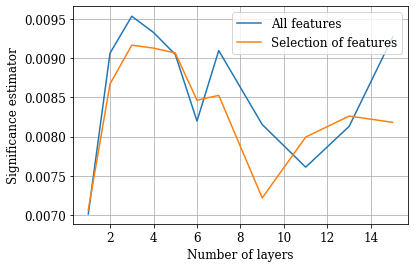

In [40]:
import matplotlib as mpl 
mpl.rcParams.update({"font.size": 12, "font.family": "serif"})
for i in range(len(depths_list)):
    x, y = zip(*sorted(list(zip(depths_list[i], max_sigs_list[i])), key=lambda x: x[0]))
    plt.plot(x, y,label=labels[i])
plt.xlabel('Number of layers')
plt.ylabel('Significance estimator')
plt.legend()
plt.grid()
plt.savefig('Images/TEST9_global_v4_sig_vs_n_layers.pdf', bbox_inches = 'tight')

In [41]:
import os
os.getpid()

33290

: 